In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cd ..

d:\Documents\CentraleSupélec\SDI\Stage\dg_few_labels\code\SSDG-MI


In [4]:
import argparse
import torch

from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer

# new imports
from yacs.config import CfgNode as CN
import copy

# datasets
import datasets.ssdg_pacs
import datasets.ssdg_officehome
import datasets.ssdg_digits_dg
import datasets.ssdg_vlcs

# trainers
import trainers.ME
import trainers.FBCSA

import matplotlib.pyplot as plt
import random
from collections import defaultdict
from dassl.data.datasets import Datum
import numpy as np


In [5]:
def extend_cfg(cfg):
    cfg.TRAINER.ME = CN()
    cfg.TRAINER.ME.CONF_THRE = 0.95  # confidence threshold
    cfg.TRAINER.ME.STRONG_TRANSFORMS = ()  # strong augmentations
    cfg.TRAINER.ME.C_OPTIM = copy.deepcopy(cfg.OPTIM)  # classifier's optim setting
    cfg.TRAINER.ME.CLASSIFIER = "normal"  # stochastic or normal

cfg = get_cfg_default()
extend_cfg(cfg)

dataset_config_file = 'configs/datasets/ssdg_officehome.yaml'
cfg.merge_from_file(dataset_config_file)

config_file = 'configs/trainers/FBCSA/ssdg_officehome.yaml'
cfg.merge_from_file(config_file)

cfg.DATASET.ROOT = '../../data'
cfg.OUTPUT_DIR = 'output/test'
cfg.SEED = 3
cfg.DATASET.SOURCE_DOMAINS = ['clipart', 'product', 'real_world']
cfg.DATASET.TARGET_DOMAINS = ['art']
# cfg.DATASET.SOURCE_DOMAINS = ['art_painting', 'cartoon', 'sketch']
# cfg.DATASET.TARGET_DOMAINS = ['photo']
# cfg.DATASET.SOURCE_DOMAINS = ['mnist', 'svhn', 'syn']
# cfg.DATASET.TARGET_DOMAINS = ['mnist_m']
# cfg.DATASET.SOURCE_DOMAINS = ['caltech', 'labelme', 'pascal']
# cfg.DATASET.TARGET_DOMAINS = ['sun']
cfg.DATASET.ONE_SOURCE_L = None
cfg.TRAINER.NAME = 'ME'
cfg.TRAINER.ME.IMBALANCE = 'exp_l_only'  # random label or not
cfg.TRAINER.ME.GAMMA = 10  # class imbalance ratio
cfg.TRAINER.ME.LAMBDA = 0
cfg.TRAINER.ME.ALPHA = 0.1

cfg.DATASET.NUM_LABELED //= 2

print(cfg)

KeyError: 'Non-existent config key: TRAINER.FBASA'

In [ ]:
set_random_seed(cfg.SEED)

In [ ]:
# import datasets.ssdg_officehome
# import datasets.ssdg_pacs
# import datasets.ssdg_digits_dg
trainer = build_trainer(cfg)

Loading trainer: MI
Building transform_train
+ resize to 224x224
+ random translation
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building transform_train
+ resize to 224x224
+ random flip
+ randaugment_fixmatch (n=2)
+ to torch tensor of range [0, 1]
+ cutout (n_holes=1, length=16)
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Loading dataset: SSDGOfficeHome
Class distribution in the labeled training set:
defaultdict(<class 'int'>, {0: 3, 1: 3, 2: 15, 3: 3, 4: 18, 5: 6, 6: 21, 7: 9, 8: 15, 9: 15, 10: 24, 11: 21, 12: 15, 13: 24, 14: 30, 15: 36, 16: 18, 17: 3, 18: 27, 19: 6, 20: 6, 21: 3, 22: 6, 23: 3, 24: 30, 25: 3, 26: 3, 27: 3, 28: 33, 29: 6, 30: 24, 31: 6, 32: 6, 33: 36, 34: 3, 35: 9, 36: 3, 37: 6, 38: 15, 39: 30, 40: 21, 41: 18, 42: 18, 43: 9, 44: 9, 45: 6, 46: 36, 47: 15, 48: 6, 49: 21, 50: 24, 51: 39, 52: 18, 53: 15, 54: 6, 55: 39, 56: 9, 57: 3, 58: 33, 59: 27, 60: 9, 61: 3, 62: 

In [ ]:
# lab2cname = {0: 'dog', 1: 'elephant', 2: 'giraffe', 3: 'guitar', 4: 'horse', 5: 'house', 6: 'person'}

import os
lab2cname = {}
for i, cname in enumerate(os.listdir('../../data/office_home_dg/real_world/train')):
    lab2cname[i] = cname

# lab2cname = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}

# lab2cname = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}

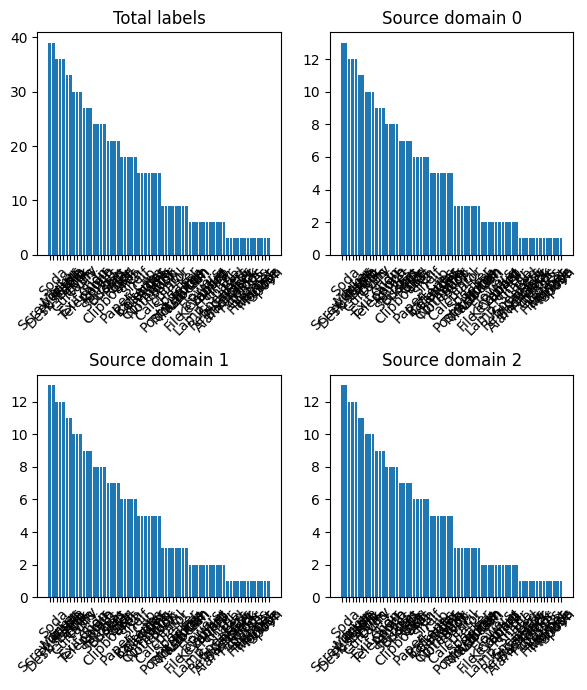

In [ ]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

train_x = trainer.dm.dataset.train_x

labels = [datum.label for datum in train_x]

# Count the frequency of each label
labels_counter = Counter(labels)
if cfg.TRAINER.FBASA.IMBALANCE == 'exp_l_only':
    labels_sorted = sorted(labels_counter.items(), key=lambda x: x[1], reverse=True)
    classes = [lab2cname[label] for label, count in labels_sorted]
    counts = [count for label, count in labels_sorted]
else:
    classes = lab2cname.values()
    counts = [labels_counter[label] for label in range(len(classes))]

train_u_d = defaultdict(list)
for datum in train_x:
    train_u_d[datum.domain].append(datum)

plt.figure(figsize=(6, 7))
plt.subplot(2, 2, 1)
plt.bar(classes, counts)
plt.xticks(rotation=45)
plt.title('Total labels')

for i, domain in enumerate(train_u_d.keys()):
    labels = [datum.label for datum in train_u_d[domain]]
    
    # Count the frequency of each label in this domain
    labels_counter = Counter(labels)
    if cfg.TRAINER.FBASA.IMBALANCE == 'exp_l_only':
        labels_sorted = sorted(labels_counter.items(), key=lambda x: x[1], reverse=True)
        classes = [lab2cname[label] for label, count in labels_sorted]
        counts = [count for label, count in labels_sorted]
    else:
        classes = lab2cname.values()
        counts = [labels_counter[label] for label in range(len(classes))]

    plt.subplot(2, 2, i+2)
    plt.bar(classes, counts)
    plt.xticks(rotation=45)
    plt.title(f'Source domain {domain}')

plt.tight_layout()
plt.show()

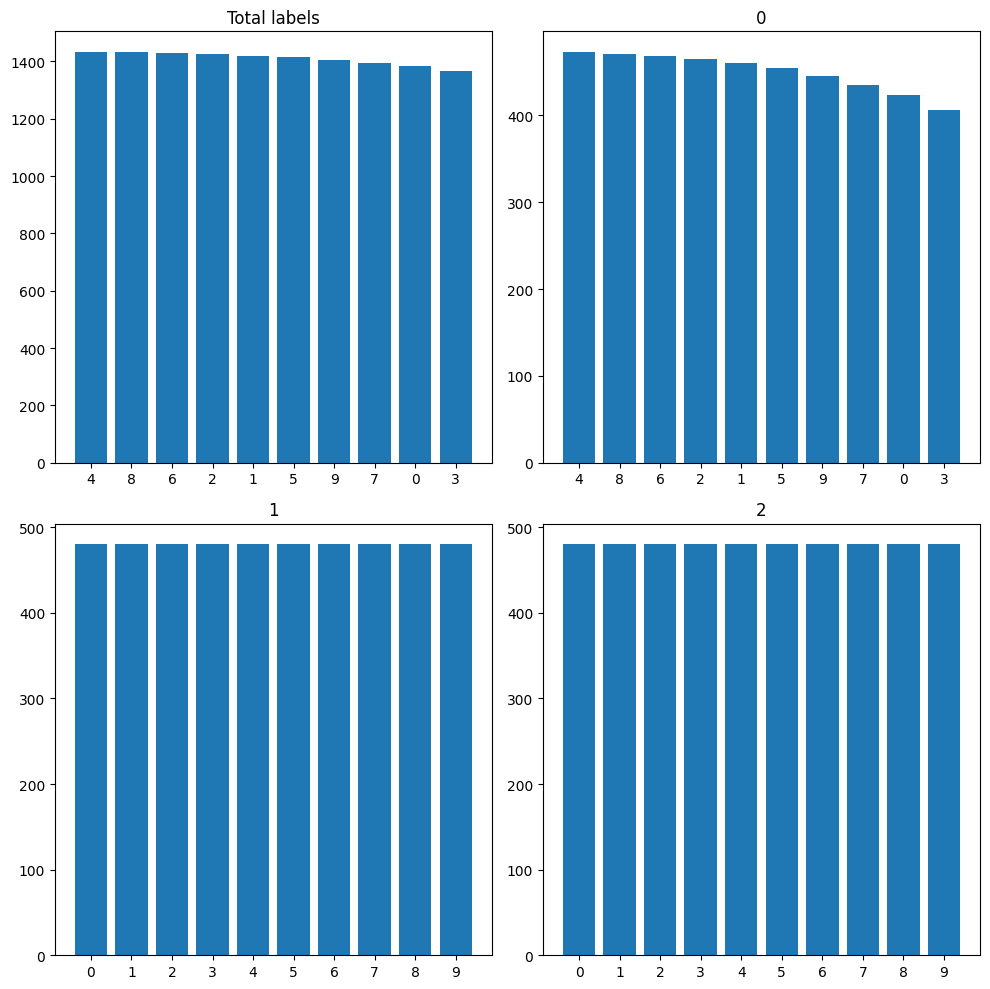

In [ ]:
train_u = trainer.dm.dataset.train_u

labels = [datum.label for datum in train_u]

# Count the frequency of each label
labels_counter = Counter(labels)
labels_sorted = sorted(labels_counter.items(), key=lambda x: x[1], reverse=True)
labels = [str(label) for label, count in labels_sorted]
counts = [count for label, count in labels_sorted]

train_u_d = defaultdict(list)
for datum in train_u:
    train_u_d[datum.domain].append(datum)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.bar(labels, counts)
plt.title('Total labels')

for i, domain in enumerate(train_u_d.keys()):
    labels = [datum.label for datum in train_u_d[domain]]
    
    # Count the frequency of each label in this domain
    labels_counter = Counter(labels)
    labels_sorted = sorted(labels_counter.items(), key=lambda x: x[1], reverse=True)
    labels = [str(label) for label, count in labels_sorted]
    counts = [count for label, count in labels_sorted]

    plt.subplot(2, 2, i+2)
    plt.bar(labels, counts)
    plt.title(domain)

plt.tight_layout()
plt.show()

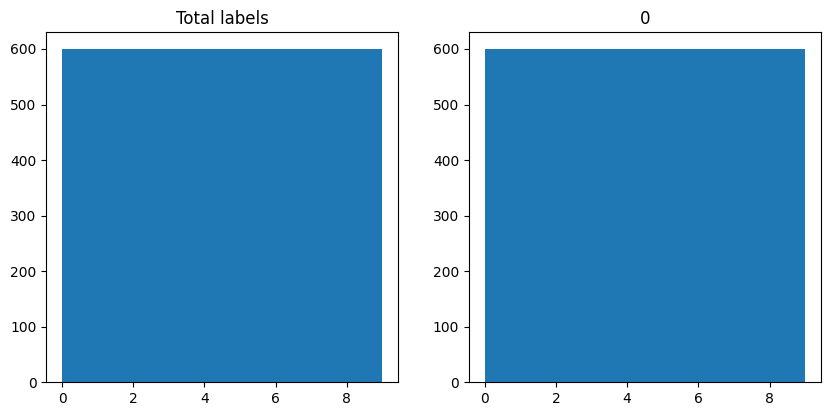

In [ ]:
test = trainer.dm.dataset.test

labels = [datum.label for datum in test]

test_d = defaultdict(list)

for datum in test:
    test_d[datum.domain].append(datum)

# histogram of total labels and labels per domain
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.hist(labels, bins=len(set(labels)))
plt.title('Total labels')

for i, domain in enumerate(test_d.keys()):
    labels = [datum.label for datum in test_d[domain]]
    plt.subplot(2, 2, i+2)
    plt.hist(labels, bins=len(set(labels)))
    plt.title(domain)

plt.show()

In [ ]:
import ast

def extract_distributions(log_file):
    labeled_dict = None
    unlabeled_dict = None
    
    with open(log_file, 'r') as file:
        for line in file:
            if 'Class distribution in the labeled training set:' in line:
                labeled_dict_line = next(file).strip()
                labeled_dict = ast.literal_eval(labeled_dict_line.split('defaultdict(<class \'int\'>, ')[1].rstrip(')'))
            elif 'Class distribution in the unlabeled training set:' in line:
                unlabeled_dict_line = next(file).strip()
                unlabeled_dict = ast.literal_eval(unlabeled_dict_line.split('defaultdict(<class \'int\'>, ')[1].rstrip(')'))

    return labeled_dict, unlabeled_dict

log_file = 'log.txt'
labeled_dict, unlabeled_dict = extract_distributions(log_file)

print("Labeled training set distribution:", labeled_dict)
print("Unlabeled training set distribution:", unlabeled_dict)


Labeled training set distribution: {0: 21, 1: 6, 2: 9, 3: 36, 4: 72, 5: 15, 6: 51}
Unlabeled training set distribution: {0: 1192, 1: 1251, 2: 1142, 3: 799, 4: 1132, 5: 566, 6: 844}


In [ ]:
np.argsort(list(labeled_dict.values()))[::-1]

array([4, 6, 3, 0, 5, 2, 1], dtype=int64)

In [ ]:
import re

match = re.match(r'\* class: (\d+) \(\)\ttotal: \d+\tcorrect: \d+\tacc: ([\d\.]+)%', '* class: 0 ()	total: 379	correct: 296	acc: 78.1%')
match.group(1), match.group(2)

('0', '78.1')

## Datasets distribution

In [ ]:
import os
import matplotlib.pyplot as plt

C:\Users\qg91v\AppData\Local\Temp\ipykernel_15132\3308340807.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(distribution[domain].keys(), rotation=45)


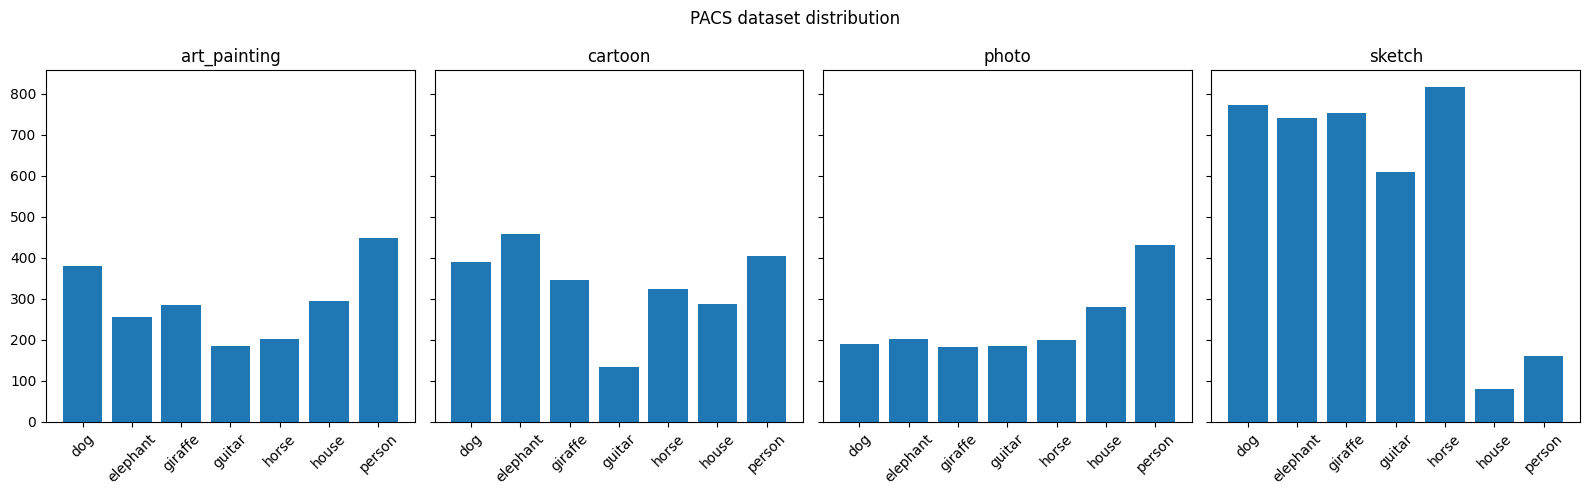

In [ ]:
dataset_path = '../../data/pacs/images'
categories = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
domains = ['art_painting', 'cartoon', 'photo', 'sketch']

# get the number of images per category per domain
distribution = {}
for domain in domains:
    domain_path = os.path.join(dataset_path, domain)
    distribution[domain] = {}
    for category in categories:
        category_path = os.path.join(domain_path, category)
        distribution[domain][category] = len(os.listdir(category_path))

# plot the distribution
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
for i, domain in enumerate(domains):
    ax = axs[i]
    ax.bar(distribution[domain].keys(), distribution[domain].values())
    ax.set_title(domain)
    ax.set_xticklabels(distribution[domain].keys(), rotation=45)
plt.suptitle('PACS dataset distribution')
plt.tight_layout()
plt.show()

In [ ]:
def exp_imbalance_l(N, C, gamma):
    '''
    N: total number of samples
    C: number of classes
    gamma: imbalance ratio

    return: list of number of samples per class with exponential imbalance
    '''
    n1 = N*(1-gamma**(-1/(C-1)))/(1-gamma**(-C/(C-1)))
    n_samples = []

    for i in range(C):
        n_samples.append(int(n1*gamma**(-i/(C-1))))

    # add remaining samples to the first classes
    for i in range(N-sum(n_samples)):
        n_samples[i] += 1

    return n_samples

C:\Users\qg91v\AppData\Local\Temp\ipykernel_15132\762787903.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(distribution[domain].keys(), rotation=45)


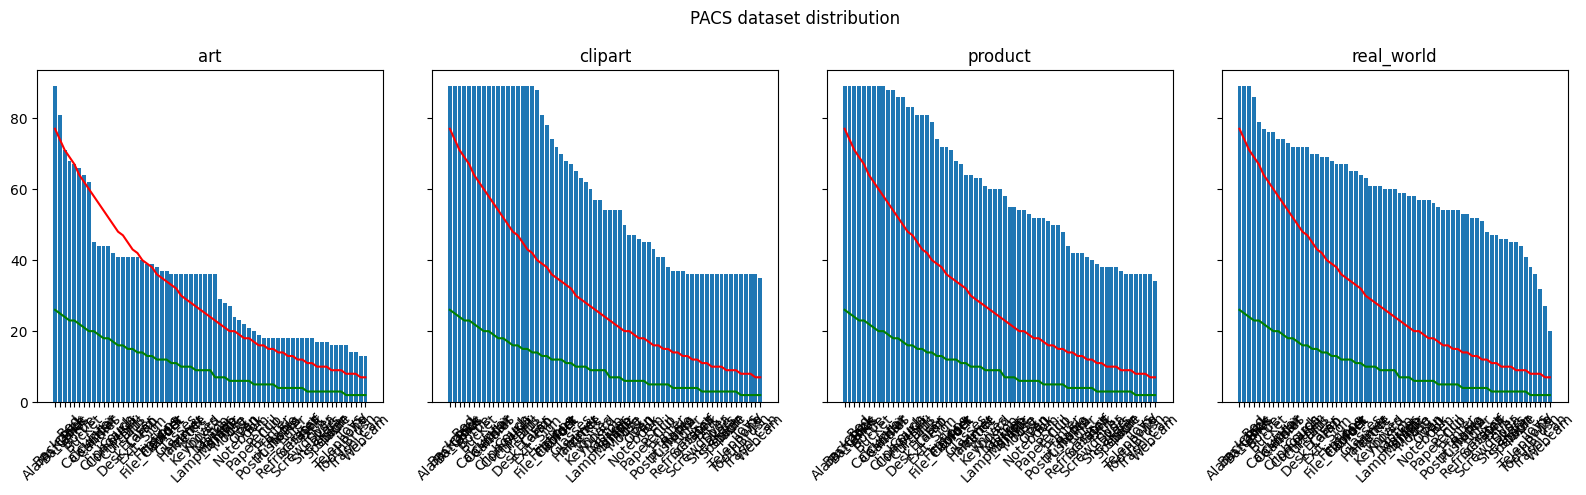

In [ ]:
dataset_path = '../../data/office_home_dg'
categories = os.listdir('../../data/office_home_dg/real_world/train')
domains = ['art', 'clipart', 'product', 'real_world']

# get the number of images per category per domain
distribution = {}
for domain in domains:
    domain_path = os.path.join(dataset_path, domain, 'train').replace(os.sep, '/')
    distribution[domain] = {}
    for category in categories:
        category_path = os.path.join(domain_path, category).replace(os.sep, '/')
        distribution[domain][category] = len(os.listdir(category_path))

# plot the distribution
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
for i, domain in enumerate(domains):
    ax = axs[i]
    # ax.bar(distribution[domain].keys(), distribution[domain].values())
    # Bar by descending order
    ax.bar([k for k, v in sorted(distribution[domain].items(), key=lambda item: item[1], reverse=True)], [v for k, v in sorted(distribution[domain].items(), key=lambda item: item[1], reverse=True)])
    ax.plot([k for k, v in sorted(distribution[domain].items(), key=lambda item: item[1], reverse=True)], exp_imbalance_l(1950, len(categories), 10), color='red')
    ax.plot([k for k, v in sorted(distribution[domain].items(), key=lambda item: item[1], reverse=True)], exp_imbalance_l(1950//3, len(categories), 10), color='green')
    ax.set_title(domain)
    ax.set_xticklabels(distribution[domain].keys(), rotation=45)
plt.suptitle('PACS dataset distribution')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

In [ ]:
a = np.array([0,2,3])
b = np.array([1,2,4])
# c = np.zeros(3)

# for i in range(3):
#     c[i] = min(a[i], b[i])

assert (a <= b).all()

In [ ]:
[0,1,2] >= [0,1,3]

False